In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings 
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vishn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vishn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validata.csv")

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
def preprocess_text(text):
    # Remove punctuation
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

train['comment_text'] = train['comment_text'].apply(preprocess_text)


In [5]:
train['comment_text_processed'] = train['comment_text'].apply(lambda x: ' '.join(x))

In [6]:
train['comment_text_processed'][15]

'juelz santanas age juelz santana year old came february th make juelz turn making song diplomat third neff signed cam label roc fella year old coming single santana town yes born really could older lloyd bank could birthday passed homie neff year old juelz death god forbid thinking equal go caculator stop changing year birth god'


### Logistic Regression 

In [19]:

X = train['comment_text_processed']
y = train['toxic']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english') 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# --- Logistic Regression without SMOTE ---
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg_model.predict(X_val_tfidf)

# Evaluate models without SMOTE
print("Logistic Regression without SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_logreg))
print("Precision:", precision_score(y_val, y_pred_logreg))
print("Recall:", recall_score(y_val, y_pred_logreg))
print("f1 socre:", f1_score(y_val, y_pred_logreg))


Logistic Regression without SMOTE:
Accuracy: 0.9564454471391866
Precision: 0.9145854145854145
Recall: 0.600327868852459
f1 socre: 0.72486144101346


In [8]:
# --- Apply SMOTE to the training set ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# --- Logistic Regression with SMOTE ---
logreg_model_smote = LogisticRegression(random_state=42)
logreg_model_smote.fit(X_train_smote, y_train_smote)
y_pred_logreg_smote = logreg_model_smote.predict(X_val_tfidf)

In [20]:
# Evaluate models with SMOTE
print("\nLogistic Regression with SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_logreg_smote))
print("Precision:", precision_score(y_val, y_pred_logreg_smote))
print("Recall:", recall_score(y_val, y_pred_logreg_smote))
print("f1 socre:", f1_score(y_val, y_pred_logreg_smote))


Logistic Regression with SMOTE:
Accuracy: 0.9109481732155167
Precision: 0.5212418300653595
Recall: 0.8367213114754098
f1 socre: 0.6423357664233577


<module 'matplotlib.pyplot' from 'C:\\Users\\vishn\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

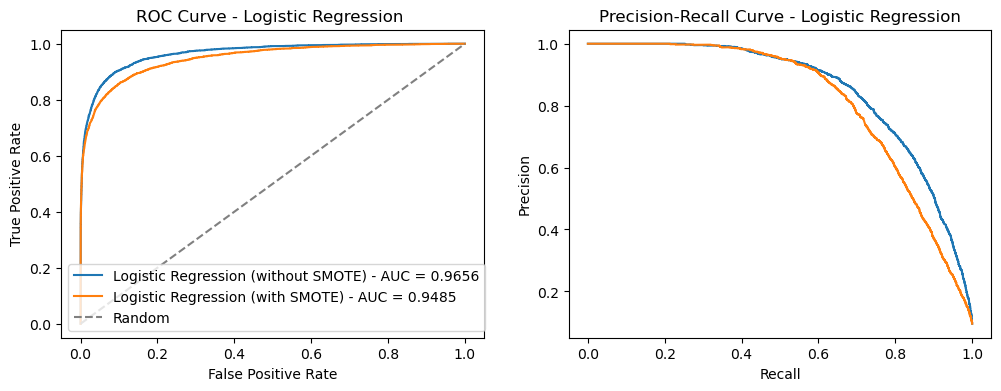

In [10]:
# Plot ROC and Precision-Recall curves for Logistic Regression without SMOTE
fpr_logreg, tpr_logreg, _ = roc_curve(y_val, logreg_model.decision_function(X_val_tfidf))
precision_logreg, recall_logreg, _ = precision_recall_curve(y_val, logreg_model.decision_function(X_val_tfidf))

fpr_logreg_smote, tpr_logreg_smote, _ = roc_curve(y_val, logreg_model_smote.decision_function(X_val_tfidf))
precision_logreg_smote, recall_logreg_smote, _ = precision_recall_curve(y_val, logreg_model_smote.decision_function(X_val_tfidf))

plt.figure(figsize=(12, 4))
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_logreg_smote = auc(fpr_logreg_smote, tpr_logreg_smote)

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (without SMOTE) - AUC = {auc_logreg:.4f}')
plt.plot(fpr_logreg_smote, tpr_logreg_smote, label=f'Logistic Regression (with SMOTE) - AUC = {auc_logreg_smote:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - Logistic Regression ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_logreg, precision_logreg, label='Logistic Regression (No SMOTE)')
plt.plot(recall_logreg_smote, precision_logreg_smote, label='Logistic Regression (with SMOTE)')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt


In [11]:
validation['comment_text'] = validation['comment_text'].apply(preprocess_text)
validation['comment_text_processed'] = validation['comment_text'].apply(lambda x: ' '.join(x))

In [12]:
X_validation = tfidf_vectorizer.transform(validation['comment_text_processed'])


In [13]:
y_valid_pred_logreg_smote = logreg_model_smote.predict(X_validation)

In [21]:
# Evaluate models with SMOTE

y =validation['toxic']
print("\nLogistic Regression with SMOTE:")
print("Accuracy:", accuracy_score(y, y_valid_pred_logreg_smote))
print("Precision:", precision_score(y, y_valid_pred_logreg_smote))
print("Recall:", recall_score(y, y_valid_pred_logreg_smote))
print("f1 socre:", f1_score(y, y_valid_pred_logreg_smote))


Logistic Regression with SMOTE:
Accuracy: 0.888883918586446
Precision: 0.4572127139364303
Recall: 0.8762886597938144
f1 socre: 0.6008997429305912


In [22]:
# Evaluate models without SMOTE
y_valid_pred_logreg = logreg_model.predict(X_validation)

print("\nLogistic Regression without SMOTE:")
print("Accuracy:", accuracy_score(y, y_valid_pred_logreg))
print("Precision:", precision_score(y, y_valid_pred_logreg))
print("Recall:", recall_score(y, y_valid_pred_logreg))
print("f1 socre:", f1_score(y, y_valid_pred_logreg))


Logistic Regression without SMOTE:
Accuracy: 0.9520912547528517
Precision: 0.8231003039513678
Recall: 0.6344892221180881
f1 socre: 0.7165916909235247


### Decision Tree 

In [15]:


# --- Decision Tree without SMOTE ---
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_tfidf, y_train)
y_pred_tree = decision_tree_model.predict(X_val_tfidf)


print("\nDecision Tree without SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_tree))
print("Precision:", precision_score(y_val, y_pred_tree))
print("Recall:", recall_score(y_val, y_pred_tree))





Decision Tree without SMOTE:
Accuracy: 0.9391802970483174
Precision: 0.6813869807000327
Recall: 0.6829508196721311


In [16]:
# --- Apply SMOTE to the training set ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)


# --- Decision Tree with SMOTE ---
decision_tree_model_smote = DecisionTreeClassifier(random_state=42)
decision_tree_model_smote.fit(X_train_smote, y_train_smote)
y_pred_tree_smote = decision_tree_model_smote.predict(X_val_tfidf)



print("\nDecision Tree with SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_tree_smote))
print("Precision:", precision_score(y_val, y_pred_tree_smote))
print("Recall:", recall_score(y_val, y_pred_tree_smote))


Decision Tree with SMOTE:
Accuracy: 0.8972864573541393
Precision: 0.475076519457805
Recall: 0.7124590163934427


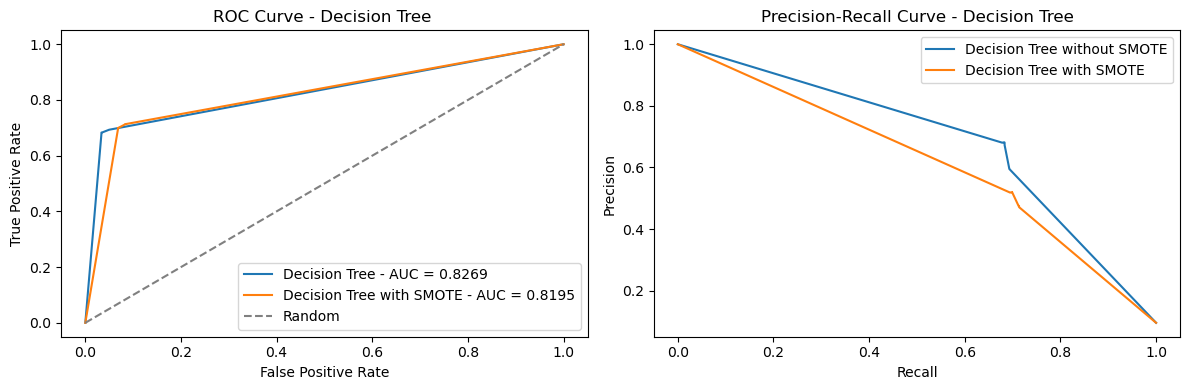

In [17]:
# ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_val, decision_tree_model.predict_proba(X_val_tfidf)[:, 1])
auc_dt = auc(fpr_dt, tpr_dt)

# Precision-Recall curve
precision_dt, recall_dt, _ = precision_recall_curve(y_val, decision_tree_model.predict_proba(X_val_tfidf)[:, 1])

# ROC curve
fpr_dt_smote, tpr_dt_smote, _ = roc_curve(y_val, decision_tree_model_smote.predict_proba(X_val_tfidf)[:, 1])
auc_dt_smote = auc(fpr_dt_smote, tpr_dt_smote)

# Precision-Recall curve
precision_dt_smote, recall_dt_smote, _ = precision_recall_curve(y_val, decision_tree_model_smote.predict_proba(X_val_tfidf)[:, 1])

# Plotting
plt.figure(figsize=(12, 4))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree - AUC = {auc_dt:.4f}')
plt.plot(fpr_dt_smote, tpr_dt_smote, label=f'Decision Tree with SMOTE - AUC = {auc_dt_smote:.4f}')  # Corrected label

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - Decision Tree ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_dt, precision_dt, label='Decision Tree without SMOTE')
plt.plot(recall_dt_smote, precision_dt_smote, label='Decision Tree with SMOTE')

plt.title('Precision-Recall Curve - Decision Tree')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
y_valid_pred_dt_smote = decision_tree_model_smote.predict(X_validation)

print("\nLogistic Regression with SMOTE:")
print("Accuracy:", accuracy_score(y, y_valid_pred_dt_smote))
print("Precision:", precision_score(y, y_valid_pred_dt_smote))
print("Recall:", recall_score(y, y_valid_pred_dt_smote))


Logistic Regression with SMOTE:
Accuracy: 0.9049876985014538
Precision: 0.5014442518775274
Recall: 0.8134957825679475


In [33]:
y_valid_pred_dt = decision_tree_model.predict(X_validation)

print("\nLogistic Regression without SMOTE:")
print("Accuracy:", accuracy_score(y, y_valid_pred_dt))
print("Precision:", precision_score(y, y_valid_pred_dt))
print("Recall:", recall_score(y, y_valid_pred_dt))


Logistic Regression without SMOTE:
Accuracy: 0.9442630284052784
Precision: 0.6771747805267359
Recall: 0.7952202436738519


### SVM

In [18]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_val_tfidf)



print("SVM without SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("Precision:", precision_score(y_val, y_pred_svm))
print("Recall:", recall_score(y_val, y_pred_svm))

SVM without SMOTE:
Accuracy: 0.9595475339976186
Precision: 0.8886433937251436
Recall: 0.6593442622950819


In [19]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

svm_model_smote = SVC(kernel='linear', random_state=42)
svm_model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = svm_model_smote.predict(X_val_tfidf)

print("\nSVM with SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_smote))
print("Precision:", precision_score(y_val, y_pred_smote))
print("Recall:", recall_score(y_val, y_pred_smote))


SVM with SMOTE:
Accuracy: 0.9056213573980072
Precision: 0.5037758346581876
Recall: 0.8311475409836065


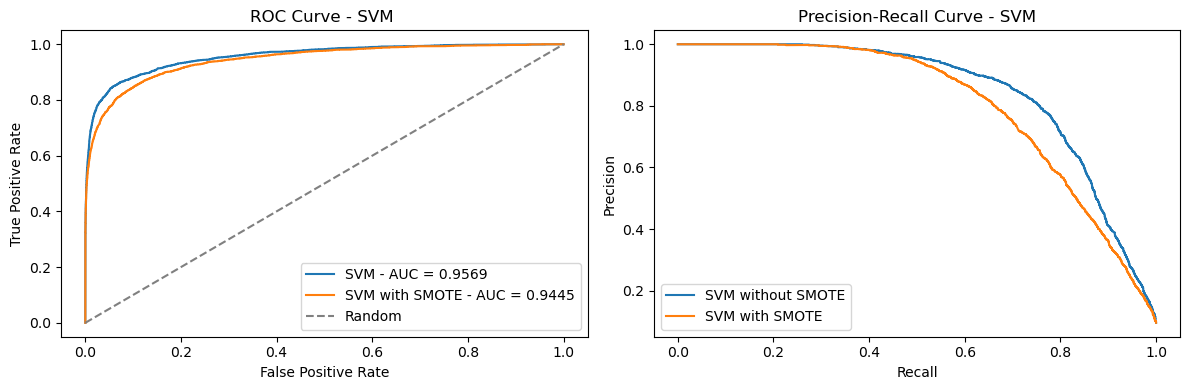

In [20]:


# ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_val, svm_model.decision_function(X_val_tfidf))
auc_svm = auc(fpr_svm, tpr_svm)

# Precision-Recall curve
precision_svm, recall_svm, _ = precision_recall_curve(y_val, svm_model.decision_function(X_val_tfidf))

# ROC curve for SVM with SMOTE
fpr_svm_smote, tpr_svm_smote, _ = roc_curve(y_val, svm_model_smote.decision_function(X_val_tfidf))
auc_svm_smote = auc(fpr_svm_smote, tpr_svm_smote)

# Precision-Recall curve for SVM with SMOTE
precision_svm_smote, recall_svm_smote, _ = precision_recall_curve(y_val, svm_model_smote.decision_function(X_val_tfidf))

# Plotting
plt.figure(figsize=(12, 4))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM - AUC = {auc_svm:.4f}')
plt.plot(fpr_svm_smote, tpr_svm_smote, label=f'SVM with SMOTE - AUC = {auc_svm_smote:.4f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - SVM ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label='SVM without SMOTE')
plt.plot(recall_svm_smote, precision_svm_smote, label='SVM with SMOTE')

plt.title('Precision-Recall Curve - SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
y_valid_pred_svm = svm_model.predict(X_validation)

print("\n SVM  with without SMOTE:")
print("Validation Accuracy:", accuracy_score(y, y_valid_pred_svm))
print("Validation Precision:", precision_score(y, y_valid_pred_svm))
print("Validation Recall:", recall_score(y, y_valid_pred_svm))


Logistic Regression with without SMOTE:
Validation Accuracy: 0.9531648400805189
Validation Precision: 0.7817522032141005
Validation Recall: 0.7066541705716963


In [35]:
y_valid_pred_svm_smote = svm_model_smote.predict(X_validation)

print("\n SVM  with SMOTE:")
print("Validation Accuracy:", accuracy_score(y, y_valid_pred_svm_smote))
print("Validation Precision:", precision_score(y, y_valid_pred_svm_smote))
print("Validation Recall:", recall_score(y, y_valid_pred_svm_smote))


Logistic Regression with SMOTE:
Validation Accuracy: 0.8874972042048759
Validation Precision: 0.45366090975431766
Validation Recall: 0.8739456419868791


### k-Nearest Neighbour 

In [10]:


knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_tfidf, y_train)
y_pred_Knn = knn_model.predict(X_val_tfidf)

print("KNN without SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_Knn))
print("Precision:", precision_score(y_val, y_pred_Knn))
print("Recall:", recall_score(y_val, y_pred_Knn))


KNN without SMOTE:
Accuracy: 0.9270226233001191
Precision: 0.8181818181818182
Recall: 0.30393442622950817


In [11]:


knn_model_smote = KNeighborsClassifier(n_neighbors=3)
knn_model_smote.fit(X_train_smote, y_train_smote)
X_test_tfidf_smote = tfidf_vectorizer.transform(X_test)
y_pred_knn_smote = knn_model_smote.predict(X_val_tfidf)

print("\nKNN with SMOTE:")
print("Accuracy:", accuracy_score(y_val, y_pred_knn_smote))
print("Precision:", precision_score(y_val, y_pred_knn_smote))
print("Recall:", recall_score(y_val, y_pred_knn_smote))


KNN with SMOTE:
Accuracy: 0.28868208309832677
Precision: 0.11339759984261263
Recall: 0.9449180327868852


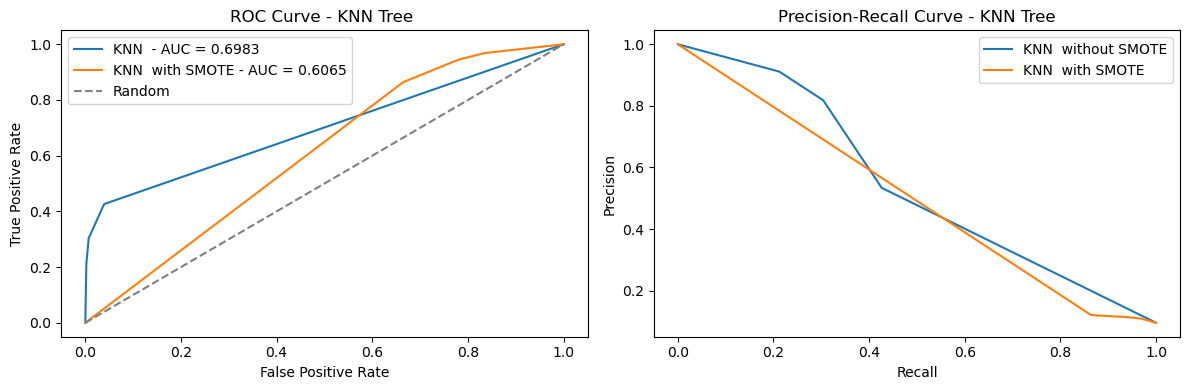

In [14]:
# ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_val, knn_model.predict_proba(X_val_tfidf)[:, 1])
auc_knn = auc(fpr_knn, tpr_knn)

# Precision-Recall curve
precision_knn, recall_knn, _ = precision_recall_curve(y_val, knn_model.predict_proba(X_val_tfidf)[:, 1])

# ROC curve
fpr_knn_smote, tpr_knn_smote, _ = roc_curve(y_val, knn_model_smote.predict_proba(X_val_tfidf)[:, 1])
auc_knn_smote = auc(fpr_knn_smote, tpr_knn_smote)

# Precision-Recall curve
precision_knn_smote, recall_knn_smote, _ = precision_recall_curve(y_val, knn_model_smote.predict_proba(X_val_tfidf)[:, 1])

# Plotting
plt.figure(figsize=(12, 4))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_knn, tpr_knn, label=f'KNN  - AUC = {auc_knn:.4f}')
plt.plot(fpr_knn_smote, tpr_knn_smote, label=f'KNN  with SMOTE - AUC = {auc_knn_smote:.4f}') 

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - KNN Tree ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_knn, precision_knn, label='KNN  without SMOTE')
plt.plot(recall_knn_smote, precision_knn_smote, label='KNN  with SMOTE')

plt.title('Precision-Recall Curve - KNN Tree')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
y_valid_pred_knn_smote = knn_model_smote.predict(X_validation)

print("\nLogistic Regression  with SMOTE:")
print("Validation Accuracy:", accuracy_score(y, y_valid_pred_knn_smote))
print("Validation Precision:", precision_score(y, y_valid_pred_knn_smote))
print("Validation Recall:", recall_score(y, y_valid_pred_knn_smote))


Logistic Regression with with SMOTE:
Validation Accuracy: 0.31371057928874974
Validation Precision: 0.11866266312507218
Validation Recall: 0.9629803186504218


In [37]:
y_valid_pred_knn = knn_model.predict(X_validation)

print("\nLogistic Regression with without SMOTE:")
print("Validation Accuracy:", accuracy_score(y, y_valid_pred_knn))
print("Validation Precision:", precision_score(y, y_valid_pred_knn))
print("Validation Recall:", recall_score(y, y_valid_pred_knn))


Logistic Regression with without SMOTE:
Validation Accuracy: 0.9276671885484231
Validation Precision: 0.7770632368703109
Validation Recall: 0.33973758200562326


### All the classifiers 

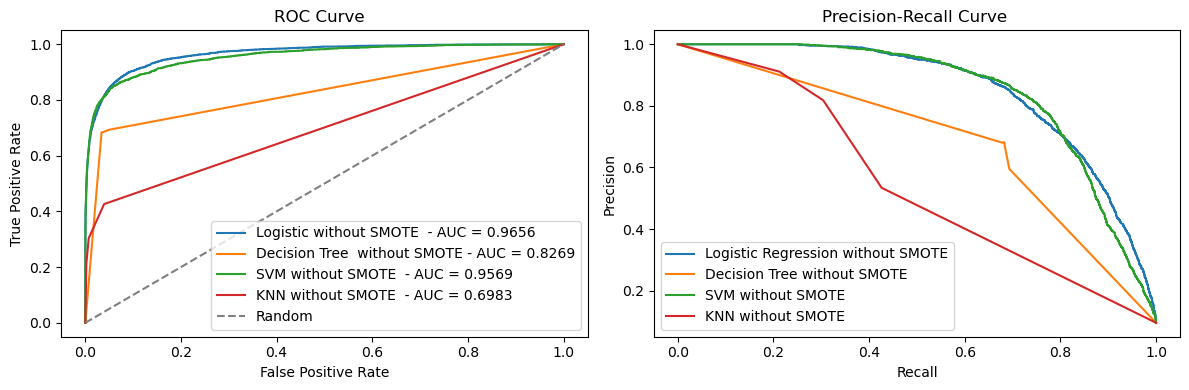

In [22]:


# Precision recall curve
precision_logreg, recall_logreg, _ = precision_recall_curve(y_val, logreg_model.decision_function(X_val_tfidf))
precision_dt, recall_dt, _ = precision_recall_curve(y_val, decision_tree_model.predict_proba(X_val_tfidf)[:, 1])
precision_svm, recall_svm, _ = precision_recall_curve(y_val, svm_model.decision_function(X_val_tfidf))
precision_knn, recall_knn, _ = precision_recall_curve(y_val, knn_model.predict_proba(X_val_tfidf)[:, 1])

# Plotting
plt.figure(figsize=(12, 4))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic without SMOTE  - AUC = {auc_logreg:.4f}')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree  without SMOTE - AUC = {auc_dt:.4f}') 
plt.plot(fpr_svm, tpr_svm, label=f'SVM without SMOTE  - AUC = {auc_svm:.4f}')
plt.plot(fpr_knn, tpr_knn, label=f'KNN without SMOTE  - AUC = {auc_knn:.4f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve  ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_logreg, precision_logreg, label='Logistic Regression without SMOTE')
plt.plot(recall_dt, precision_dt, label='Decision Tree without SMOTE')
plt.plot(recall_svm, precision_svm, label='SVM without SMOTE')
plt.plot(recall_knn, precision_knn, label='KNN without SMOTE')

plt.title('Precision-Recall Curve ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


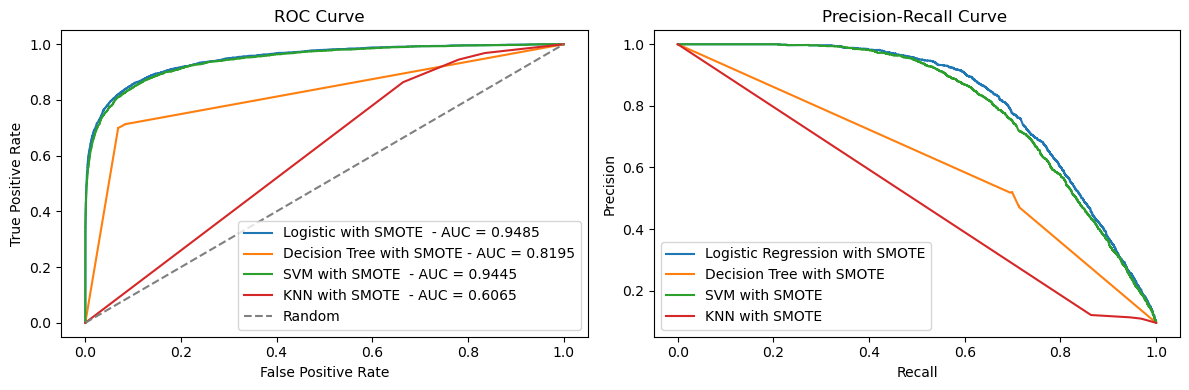

In [23]:
# ROC curve
fpr_logreg_smote, tpr_logreg_smote, _ = roc_curve(y_val, logreg_model_smote.decision_function(X_val_tfidf))
auc_logreg_smote = auc(fpr_logreg_smote, tpr_logreg_smote)

fpr_dt_smote, tpr_dt_smote, _ = roc_curve(y_val, decision_tree_model_smote.predict_proba(X_val_tfidf)[:, 1])
auc_dt_smote = auc(fpr_dt_smote, tpr_dt_smote)

fpr_svm_smote, tpr_svm_smote, _ = roc_curve(y_val, svm_model_smote.decision_function(X_val_tfidf))
auc_svm_smote = auc(fpr_svm_smote, tpr_svm_smote)

fpr_knn_smote, tpr_knn_smote, _ = roc_curve(y_val, knn_model_smote.predict_proba(X_val_tfidf)[:, 1])
auc_knn_smote = auc(fpr_knn_smote, tpr_knn_smote)

# Precision-Recall curve
precision_logreg_smote, recall_logreg_smote, _ = precision_recall_curve(y_val, logreg_model_smote.decision_function(X_val_tfidf))
precision_dt_smote, recall_dt_smote, _ = precision_recall_curve(y_val, decision_tree_model_smote.predict_proba(X_val_tfidf)[:, 1])
precision_svm_smote, recall_svm_smote, _ = precision_recall_curve(y_val, svm_model_smote.decision_function(X_val_tfidf))
precision_knn_smote, recall_knn_smote, _ = precision_recall_curve(y_val, knn_model_smote.predict_proba(X_val_tfidf)[:, 1])

# Plotting
plt.figure(figsize=(12, 4))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr_logreg_smote, tpr_logreg_smote, label=f'Logistic with SMOTE  - AUC = {auc_logreg_smote:.4f}')
plt.plot(fpr_dt_smote, tpr_dt_smote, label=f'Decision Tree with SMOTE - AUC = {auc_dt_smote:.4f}') 
plt.plot(fpr_svm_smote, tpr_svm_smote, label=f'SVM with SMOTE  - AUC = {auc_svm_smote:.4f}')
plt.plot(fpr_knn_smote, tpr_knn_smote, label=f'KNN with SMOTE  - AUC = {auc_knn_smote:.4f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve  ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_logreg_smote, precision_logreg_smote, label='Logistic Regression with SMOTE')
plt.plot(recall_dt_smote, precision_dt_smote, label='Decision Tree with SMOTE')
plt.plot(recall_svm_smote, precision_svm_smote, label='SVM with SMOTE')
plt.plot(recall_knn_smote, precision_knn_smote, label='KNN with SMOTE')

plt.title('Precision-Recall Curve ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()
